In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [2]:
data_path='D:/Robotics Master/Third semester/Thesis_Data/data3/train'

In [3]:
#from sklearn.model_selection import train_test_split

#train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)



image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

training_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

test_set = image_generator.flow_from_directory(batch_size=16,
                                                 directory=data_path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 4877 images belonging to 2 classes.
Found 1218 images belonging to 2 classes.


In [4]:
# add preprocessing layer to the front of VGG

img_height,img_width = 224,224 
num_classes = 2
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
vgg = VGG16(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))


for layer in vgg.layers:
    layer.trainable = False

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
x= vgg.output

x= GlobalAveragePooling2D()(x)
x= tf.keras.layers.BatchNormalization()(x)
x= Dropout(0.7)(x)
#x= Dense(512,activation='relu')(x) 
x= Dense(128,activation='relu')(x)
x= Dropout(0.7)(x)
x= Dense(64,activation='relu')(x)
x= tf.keras.layers.BatchNormalization()(x)
x= Dropout(0.7)(x)

preds=Dense(2,activation='softmax')(x) #FC-layer

model=Model(inputs=vgg.input,outputs=preds)
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

checkpoint = [EarlyStopping(monitor='val_loss', patience=3),
              ModelCheckpoint('modelrv2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')]

history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
    callbacks = [checkpoint]
    
    
)



Epoch 1/15
305/305 [==============================] - 113s 359ms/step - loss: 0.6523 - accuracy: 0.7519 - val_loss: 0.4563 - val_accuracy: 0.7767
Epoch 2/15
305/305 [==============================] - 110s 361ms/step - loss: 0.3820 - accuracy: 0.8546 - val_loss: 0.2947 - val_accuracy: 0.8834
Epoch 3/15
305/305 [==============================] - 110s 361ms/step - loss: 0.3247 - accuracy: 0.8755 - val_loss: 0.2607 - val_accuracy: 0.8875
Epoch 4/15
305/305 [==============================] - 109s 359ms/step - loss: 0.2922 - accuracy: 0.8903 - val_loss: 0.2450 - val_accuracy: 0.8974
Epoch 5/15
305/305 [==============================] - 112s 368ms/step - loss: 0.2693 - accuracy: 0.8997 - val_loss: 0.2403 - val_accuracy: 0.8998
Epoch 6/15
305/305 [==============================] - 112s 369ms/step - loss: 0.2560 - accuracy: 0.9014 - val_loss: 0.2359 - val_accuracy: 0.9007
Epoch 7/15
305/305 [==============================] - 110s 362ms/step - loss: 0.2428 - accuracy: 0.9042 - val_loss: 0.2270 -

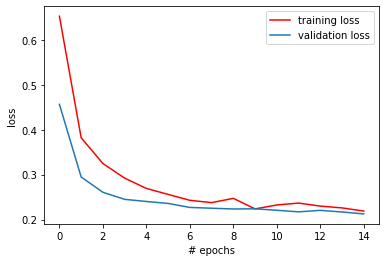

In [7]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


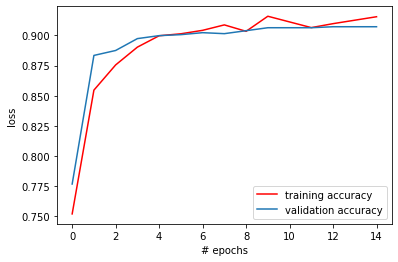

In [8]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')

plt.legend()
plt.show()